In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import json
import matplotlib.pyplot as plt

In [2]:
"""

基于pytorch的网络编写
实现一个网络完成一个简单nlp任务
判断文本中是否某个特定的字符出现的位置

模型结构：x -> embedding -> rnn -> linear -> y
损失函数：交叉熵
优化器：adam

输入：文本序列
输出：字符'a'出现的位置

"""

"\n\n基于pytorch的网络编写\n实现一个网络完成一个简单nlp任务\n判断文本中是否某个特定的字符出现的位置\n\n模型结构：x -> embedding -> rnn -> linear -> y\n损失函数：交叉熵\n优化器：adam\n\n输入：文本序列\n输出：字符'a'出现的位置\n\n"

In [3]:
class TorchModel(nn.Module):
    def __init__(self, vector_dim, rnn_hidden_size, num_classification,vocab):
        super(TorchModel, self).__init__()
        self.embedding = nn.Embedding(len(vocab), vector_dim)  #embedding层
        self.rnn = nn.RNN(vector_dim, rnn_hidden_size, batch_first=True)    #rnn层
        self.classify = nn.Linear(rnn_hidden_size, num_classification)       #全连接层
        self.loss = nn.CrossEntropyLoss()                                    #损失函数

    #当输入真实标签，返回loss值；无真实标签，返回预测值
    def forward(self, x, y=None):
        x = self.embedding(x)                      #(batch_size, sen_len) -> (batch_size, sen_len, vector_dim)
        _, x = self.rnn(x)                            #(batch_size, sen_len, vector_dim) -> (batch_size, 1, rnn_hidden_size)
        x = x.squeeze()                            #(batch_size, 1, rnn_hidden_size) -> (batch_size, rnn_hidden_size)
        y_pred = self.classify(x)                       #(batch_size, rnn_hidden_size) -> (batch_size, num_classification)

        if y is not None:
            return self.loss(y_pred, y)   #预测值和真实值计算损失
        else:
            return y_pred                 #输出预测结果


In [4]:
def build_vocab()->dict:
    '''
    构建词典,将每个字映射到一个数字,并返回
    :return: 返回一个字典
    '''
    chars = "abcdefghijklmnopqrstuvwxyz"  #字符集
    vocab = {"<pad>":0}
    for index, char in enumerate(chars):
        vocab[char] = index+1   #每个字对应一个序号
    vocab['<unk>'] = len(vocab) #26
    return vocab

In [5]:
def build_sample(vocab, sentence_length)->tuple:
    '''
    构建样本,随机生成一个长度为sentence_length的字符串,返回字符串对应的数字列表和a的位置
    其中a的位置从1开始计数,如果字符串中没有a,则返回0
    :param vocab: 词典
    :param sentence_length: 句子长度
    :return: 返回字符串对应的数字列表和a的位置
    '''
    #随机从字表选取sentence_length个字，可能重复
    x = [random.choice(list(vocab.keys())) for _ in range(sentence_length)]
    y = x.index('a')+1 if 'a' in x else 0
    x = [vocab.get(word, vocab['<unk>']) for word in x]  #将字转换为数字
    return x, y


In [6]:
def build_dataset(sample_length, vocab, sentence_length)->tuple:
    '''
    构建数据集,包括输入和标签,输入是一个二维的数字列表,标签是一个数字列表
    :param sample_length: 样本数量
    :param vocab: 词典
    :param sentence_length: 句子长度
    :return: 返回一个元组,包括输入和标签
    '''
    dataset_x = []
    dataset_y = []
    for i in range(sample_length):
        x, y = build_sample(vocab, sentence_length)
        dataset_x.append(x)
        dataset_y.append(y)
    return torch.LongTensor(dataset_x), torch.LongTensor(dataset_y)


In [7]:
def evaluate(model, vocab, sample_length)->float:
    '''
    评估模型效果,打印正确率
    :param model: 模型
    :param vocab: 词典
    :param sample_length: 样本长度
    :return: 返回正确率
    '''
    model.eval()
    x, y = build_dataset(300, vocab, sample_length)   #建立300个用于测试的样本
    print("本次预测集中共有%d个样本"%len(x))
    for i in range(sample_length+1):
        print("\t标签%d的个数为%d"%(i, len([j for j in y if j == i])))
    correct, wrong = 0, 0
    with torch.no_grad():
        y_pred = model(x)   #预测
        y_pred = torch.argmax(y_pred, dim=1)    #取预测结果中概率最大的位置为预测标签
        for y_p, y_t in zip(y_pred, y):  #与真实标签进行对比
            if y_p == y_t:
                correct += 1
            else:
                wrong += 1
    print("正确预测个数：%d, 正确率：%f"%(correct, correct/(correct+wrong)))
    return correct/(correct+wrong)

In [8]:
def main():
    '''
    主函数,训练模型,并保存模型和词典
    '''
    #配置参数
    epoch_num = 30        #训练轮数
    batch_size = 20       #每次训练样本个数
    train_sample = 500    #每轮训练总共训练的样本总数
    char_dim = 20         #每个字的维度
    sentence_length = 15   #样本文本长度
    rnn_hidden_size = 50  #rnn隐藏层大小
    num_classification = sentence_length+1  #分类数
    learning_rate = 0.005 #学习率
    # 建立字表
    vocab = build_vocab()
    # 建立模型
    model = TorchModel(char_dim, rnn_hidden_size, num_classification, vocab)
    # 选择优化器
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
    log = []
    # 训练过程
    for epoch in range(epoch_num):
        model.train()
        watch_loss = []
        for batch in range(int(train_sample / batch_size)):
            x, y = build_dataset(batch_size, vocab, sentence_length) #构造一组训练样本
            optim.zero_grad()    #梯度归零
            loss = model(x, y)   #计算loss
            loss.backward()      #计算梯度
            optim.step()         #更新权重
            watch_loss.append(loss.item())
        print("=========\n第%d轮平均loss:%f" % (epoch + 1, np.mean(watch_loss)))
        acc = evaluate(model, vocab, sentence_length)   #测试本轮模型结果
        log.append([acc, np.mean(watch_loss)])
    #画图
    plt.plot(range(len(log)), [l[0] for l in log], label="acc")  #画acc曲线
    plt.plot(range(len(log)), [l[1] for l in log], label="loss")  #画loss曲线
    plt.legend()
    plt.show()
    #保存模型
    torch.save(model.state_dict(), "model.pth")
    # 保存词表
    with open('vocab.json', 'w') as f:
        json.dump(vocab, f, ensure_ascii=False, indent=2)
    return

In [9]:
def predict(model_path, vocab_path, input_strings):
    '''
    预测函数
    :param model_path: 模型路径
    :param vocab_path: 词典路径
    :param input_strings: 输入字符串列表
    :return: 无返回
    '''
    char_dim = 20  # 每个字的维度
    sentence_length = 15  # 样本文本长度
    num_classification = sentence_length + 1  # 分类数
    rnn_hidden_size = 50  # rnn隐藏层大小
    with open(vocab_path, 'r') as f:
        vocab = json.load(f)    #加载词典
    model = TorchModel(char_dim, rnn_hidden_size, num_classification, vocab)  #建立模型
    model.load_state_dict(torch.load(model_path))             #加载训练好的权重
    x = []
    for input_string in input_strings:
        x.append([vocab[char] for char in input_string])  #将输入序列化
    model.eval()   #测试模式
    with torch.no_grad():  #不计算梯度
        result = model.forward(torch.LongTensor(x))  #模型预测
    for i, input_string in enumerate(input_strings):    #enumerate同时返回索引和值
        print("输入：%s, 预测类别：%d, 概率值：%f" % (input_string, torch.argmax(result[i]).item(), torch.softmax(result[i], dim=0)[torch.argmax(result[i])].item()))


第1轮平均loss:2.031554
本次预测集中共有300个样本
	标签0的个数为173
	标签1的个数为10
	标签2的个数为8
	标签3的个数为21
	标签4的个数为10
	标签5的个数为7
	标签6的个数为6
	标签7的个数为11
	标签8的个数为9
	标签9的个数为7
	标签10的个数为8
	标签11的个数为7
	标签12的个数为6
	标签13的个数为7
	标签14的个数为9
	标签15的个数为1
正确预测个数：173, 正确率：0.576667
第2轮平均loss:1.769737
本次预测集中共有300个样本
	标签0的个数为180
	标签1的个数为9
	标签2的个数为14
	标签3的个数为6
	标签4的个数为14
	标签5的个数为4
	标签6的个数为9
	标签7的个数为6
	标签8的个数为4
	标签9的个数为7
	标签10的个数为8
	标签11的个数为9
	标签12的个数为8
	标签13的个数为6
	标签14的个数为6
	标签15的个数为10
正确预测个数：181, 正确率：0.603333
第3轮平均loss:1.558349
本次预测集中共有300个样本
	标签0的个数为169
	标签1的个数为13
	标签2的个数为13
	标签3的个数为11
	标签4的个数为8
	标签5的个数为9
	标签6的个数为8
	标签7的个数为8
	标签8的个数为8
	标签9的个数为10
	标签10的个数为8
	标签11的个数为5
	标签12的个数为11
	标签13的个数为4
	标签14的个数为7
	标签15的个数为8
正确预测个数：179, 正确率：0.596667
第4轮平均loss:1.453693
本次预测集中共有300个样本
	标签0的个数为169
	标签1的个数为10
	标签2的个数为12
	标签3的个数为8
	标签4的个数为13
	标签5的个数为12
	标签6的个数为9
	标签7的个数为10
	标签8的个数为6
	标签9的个数为8
	标签10的个数为11
	标签11的个数为9
	标签12的个数为7
	标签13的个数为3
	标签14的个数为5
	标签15的个数为8
正确预测个数：195, 正确率：0.650000
第5轮平均loss:0.808571
本次预测集中共有300个样本
	标签0的个数为182
	标签1的个数为7
	标签2的个数为9
	标签3的个数为

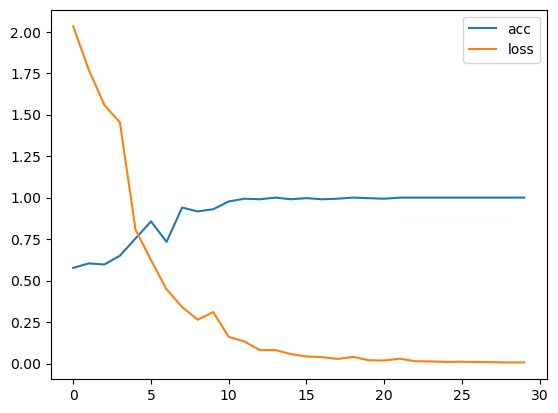

In [10]:
if __name__ == "__main__":
    main()

In [11]:

test_strings = [
    "defgijklmnpqrtu",
    "bcfghijklmnaops",
    "klamnoqdefghrst",
    "bbbbbbbbbbbbade"
]

predict("model.pth", "vocab.json", test_strings)

输入：defgijklmnpqrtu, 预测类别：0, 概率值：0.999348
输入：bcfghijklmnaops, 预测类别：12, 概率值：0.991295
输入：klamnoqdefghrst, 预测类别：3, 概率值：0.992993
输入：bbbbbbbbbbbbade, 预测类别：13, 概率值：0.996672
